<a href="https://colab.research.google.com/github/JustSerhii/PCA/blob/main/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import time

In [4]:
print("Завантаження та підготовка даних MNIST...")
# Завантаження даних
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Перетворення даних у numpy масиви
X = np.array([x[0].numpy().reshape(-1) for x in train_dataset])  # 60000 x 784
y = np.array([x[1] for x in train_dataset])
X_test = np.array([x[0].numpy().reshape(-1) for x in test_dataset])
y_test = np.array([x[1] for x in test_dataset])

print(f"Розмір тренувального набору: {X.shape}")
print(f"Розмір тестового набору: {X_test.shape}")

Завантаження та підготовка даних MNIST...


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.63MB/s]


Розмір тренувального набору: (60000, 784)
Розмір тестового набору: (10000, 784)


In [5]:
# Масштабування даних для PCA
print("\nВиконання PCA аналізу...")
start_time = time.time()
X_scaled = StandardScaler().fit_transform(X)

# Застосування PCA зі збереженням 99% дисперсії
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA завершено за {time.time() - start_time:.2f} секунд")
print(f'Кількість головних компонент: {X_pca.shape[1]}')
print(f'Збережена дисперсія: {sum(pca.explained_variance_ratio_):.4f}')


Виконання PCA аналізу...
PCA завершено за 2.03 секунд
Кількість головних компонент: 543
Збережена дисперсія: 0.9901



Створення масок для різних порогових значень:
Поріг 0.2981 (видалення 10% найменш важливих пікселів): збережено 705 пікселів (89.92%)
Поріг 0.7704 (видалення 25% найменш важливих пікселів): збережено 588 пікселів (75.00%)
Поріг 0.7971 (видалення 40% найменш важливих пікселів): збережено 470 пікселів (59.95%)
Поріг 0.8128 (видалення 50% найменш важливих пікселів): збережено 392 пікселів (50.00%)
Поріг 0.8342 (видалення 60% найменш важливих пікселів): збережено 314 пікселів (40.05%)
Поріг 0.8882 (видалення 75% найменш важливих пікселів): збережено 196 пікселів (25.00%)


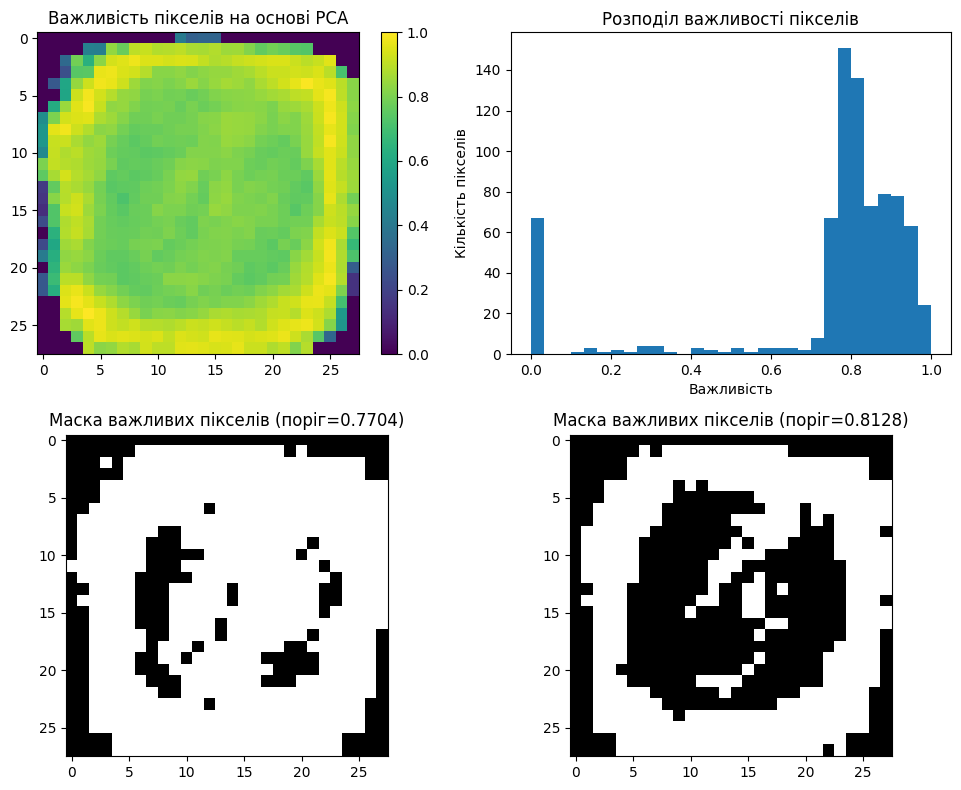

In [6]:
# Визначення важливості пікселів на основі PCA компонент
importance = np.sum(np.abs(pca.components_), axis=0)
importance = importance / np.max(importance)  # Нормалізація для кращої інтерпретації

# Створення масок для різних порогових значень
percentiles = [10, 25, 40, 50, 60, 75]
thresholds = [np.percentile(importance, p) for p in percentiles]
masks = []

print("\nСтворення масок для різних порогових значень:")
for i, threshold in enumerate(thresholds):
    mask = importance > threshold
    kept_pixels = np.sum(mask)
    print(f"Поріг {threshold:.4f} (видалення {percentiles[i]}% найменш важливих пікселів): збережено {kept_pixels} пікселів ({kept_pixels/784*100:.2f}%)")
    masks.append(mask)

# Візуалізація важливості пікселів
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.imshow(importance.reshape(28, 28), cmap='viridis')
plt.colorbar()
plt.title("Важливість пікселів на основі PCA")

plt.subplot(2, 2, 2)
plt.hist(importance, bins=30)
plt.title("Розподіл важливості пікселів")
plt.xlabel("Важливість")
plt.ylabel("Кількість пікселів")

# Візуалізація масок для різних порогів
plt.subplot(2, 2, 3)
plt.imshow(masks[1].reshape(28, 28), cmap='gray')
plt.title(f"Маска важливих пікселів (поріг={thresholds[1]:.4f})")

plt.subplot(2, 2, 4)
plt.imshow(masks[3].reshape(28, 28), cmap='gray')
plt.title(f"Маска важливих пікселів (поріг={thresholds[3]:.4f})")

plt.tight_layout()
plt.show()

In [16]:
import torch.nn as nn

class SimpleNet(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(16, 16)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [10]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test, input_dim, epochs=5, batch_size=256):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)

    model = SimpleNet(input_dim)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = loss_fn(outputs, batch_y)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)

        model.eval()
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long)
        with torch.no_grad():
            outputs = model(X_test_tensor)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == y_test_tensor).sum().item()

        test_accuracy = 100 * correct / len(y_test)
        test_accuracies.append(test_accuracy)

        print(f'Епоха [{epoch+1}/{epochs}] - Тренування: {train_accuracy:.2f}%, Тестування: {test_accuracy:.2f}%')

    return model, train_accuracies, test_accuracies

In [11]:
# Базова модель
print("\nТренування базової моделі (всі пікселі)...")
model_full, base_train_acc, base_test_acc = train_and_evaluate_model(X, y, X_test, y_test, input_dim=784)

# Моделі з масками
results = []

for i, mask in enumerate(masks):
    X_masked = X[:, mask]
    X_test_masked = X_test[:, mask]
    kept_pixels = np.sum(mask)

    print(f"\nТренування моделі з порогом {thresholds[i]:.4f} (збережено {kept_pixels} пікселів, {kept_pixels/784*100:.2f}%)")

    model_masked, train_acc, test_acc = train_and_evaluate_model(
        X_masked, y, X_test_masked, y_test, input_dim=kept_pixels
    )

    results.append({
        'threshold': thresholds[i],
        'percentile': percentiles[i],
        'kept_pixels': kept_pixels,
        'kept_percentage': kept_pixels / 784 * 100,
        'final_train_acc': train_acc[-1],
        'final_test_acc': test_acc[-1],
        'train_history': train_acc,
        'test_history': test_acc
    })


Тренування базової моделі (всі пікселі)...
Епоха [1/5] - Тренування: 69.83%, Тестування: 88.27%
Епоха [2/5] - Тренування: 89.38%, Тестування: 91.15%
Епоха [3/5] - Тренування: 91.22%, Тестування: 92.17%
Епоха [4/5] - Тренування: 92.25%, Тестування: 92.73%
Епоха [5/5] - Тренування: 92.84%, Тестування: 93.04%

Тренування моделі з порогом 0.2981 (збережено 705 пікселів, 89.92%)
Епоха [1/5] - Тренування: 69.58%, Тестування: 89.10%
Епоха [2/5] - Тренування: 89.82%, Тестування: 91.34%
Епоха [3/5] - Тренування: 91.53%, Тестування: 92.31%
Епоха [4/5] - Тренування: 92.41%, Тестування: 92.98%
Епоха [5/5] - Тренування: 93.13%, Тестування: 93.23%

Тренування моделі з порогом 0.7704 (збережено 588 пікселів, 75.00%)
Епоха [1/5] - Тренування: 68.84%, Тестування: 88.28%
Епоха [2/5] - Тренування: 89.42%, Тестування: 90.95%
Епоха [3/5] - Тренування: 91.19%, Тестування: 91.76%
Епоха [4/5] - Тренування: 91.92%, Тестування: 92.43%
Епоха [5/5] - Тренування: 92.50%, Тестування: 92.50%

Тренування моделі з по

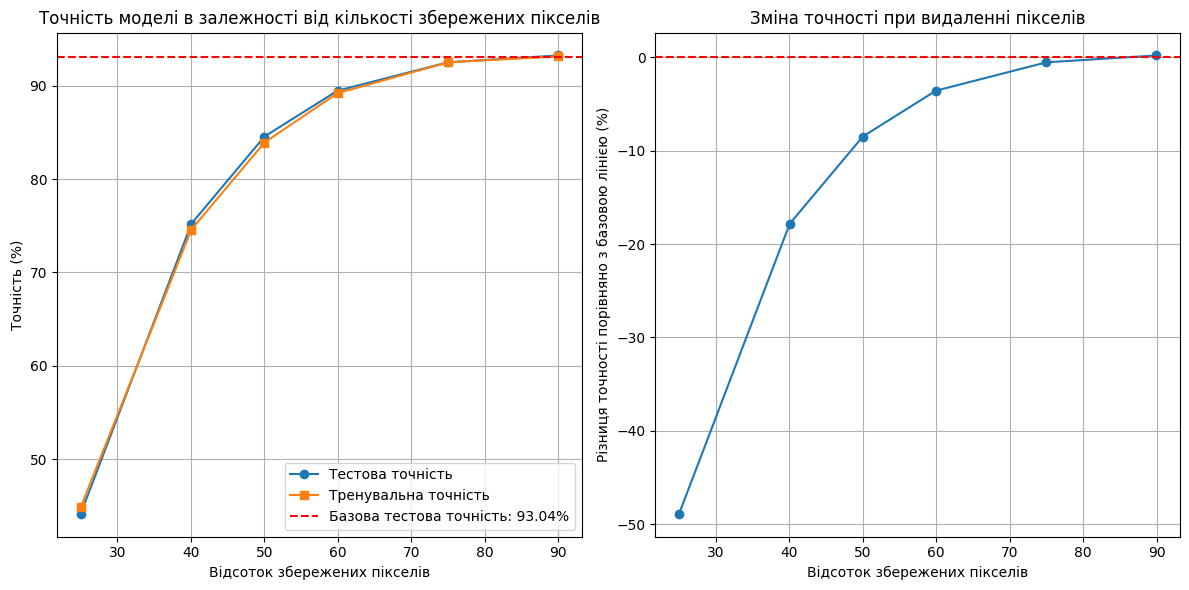

In [12]:
# Візуалізація результатів
plt.figure(figsize=(12, 6))

# Графік точності в залежності від кількості пікселів
plt.subplot(1, 2, 1)
kept_percentages = [r['kept_percentage'] for r in results]
test_accs = [r['final_test_acc'] for r in results]
train_accs = [r['final_train_acc'] for r in results]

plt.plot(kept_percentages, test_accs, 'o-', label='Тестова точність')
plt.plot(kept_percentages, train_accs, 's-', label='Тренувальна точність')
plt.axhline(y=base_test_acc[-1], color='r', linestyle='--', label=f'Базова тестова точність: {base_test_acc[-1]:.2f}%')
plt.xlabel('Відсоток збережених пікселів')
plt.ylabel('Точність (%)')
plt.title('Точність моделі в залежності від кількості збережених пікселів')
plt.legend()
plt.grid(True)

# Графік втрат точності в залежності від кількості пікселів
plt.subplot(1, 2, 2)
accuracy_diffs = [acc - base_test_acc[-1] for acc in test_accs]
plt.plot(kept_percentages, accuracy_diffs, 'o-')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Відсоток збережених пікселів')
plt.ylabel('Різниця точності порівняно з базовою лінією (%)')
plt.title('Зміна точності при видаленні пікселів')
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
# Аналіз результатів
print("\nРезультати тренування моделей з різними масками:")
for r in results:
    print(f"Поріг: {r['threshold']:.4f}, Видалено {r['percentile']}% пікселів, "
          f"Збережено: {r['kept_pixels']} ({r['kept_percentage']:.2f}%), "
          f"Тренувальна точність: {r['final_train_acc']:.2f}%, "
          f"Тестова точність: {r['final_test_acc']:.2f}%, "
          f"Різниця точності: {r['final_test_acc'] - base_test_acc[-1]:.2f}%")

# Знаходження оптимального порогу (максимальна точність з мінімальною кількістю пікселів)
# Спочатку знаходимо моделі з точністю не нижче базової
viable_indices = [i for i, r in enumerate(results) if r['final_test_acc'] >= base_test_acc[-1]]
if viable_indices:
    # Серед них вибираємо модель з найменшою кількістю пікселів
    optimal_idx = min(viable_indices, key=lambda i: results[i]['kept_pixels'])
    optimal_result = results[optimal_idx]
    optimal_mask = masks[optimal_idx]
else:
    # Якщо таких немає, вибираємо модель з найменшою втратою точності
    optimal_idx = np.argmax([r['final_test_acc'] for r in results])
    optimal_result = results[optimal_idx]
    optimal_mask = masks[optimal_idx]

print("\nОптимальний поріг:")
print(f"Поріг: {optimal_result['threshold']:.4f}")
print(f"Кількість збережених пікселів: {optimal_result['kept_pixels']} ({optimal_result['kept_percentage']:.2f}%)")
print(f"Точність на тестовому наборі: {optimal_result['final_test_acc']:.2f}%")
print(f"Різниця точності порівняно з базовою лінією: {optimal_result['final_test_acc'] - base_test_acc[-1]:.2f}%")

# Збереження оптимальної маски
np.save('optimal_mnist_mask.npy', optimal_mask)
print("Оптимальна маска збережена у файлі 'optimal_mnist_mask.npy'")


Результати тренування моделей з різними масками:
Поріг: 0.2981, Видалено 10% пікселів, Збережено: 705 (89.92%), Тренувальна точність: 93.13%, Тестова точність: 93.23%, Різниця точності: 0.19%
Поріг: 0.7704, Видалено 25% пікселів, Збережено: 588 (75.00%), Тренувальна точність: 92.50%, Тестова точність: 92.50%, Різниця точності: -0.54%
Поріг: 0.7971, Видалено 40% пікселів, Збережено: 470 (59.95%), Тренувальна точність: 89.20%, Тестова точність: 89.46%, Різниця точності: -3.58%
Поріг: 0.8128, Видалено 50% пікселів, Збережено: 392 (50.00%), Тренувальна точність: 83.91%, Тестова точність: 84.55%, Різниця точності: -8.49%
Поріг: 0.8342, Видалено 60% пікселів, Збережено: 314 (40.05%), Тренувальна точність: 74.59%, Тестова точність: 75.21%, Різниця точності: -17.83%
Поріг: 0.8882, Видалено 75% пікселів, Збережено: 196 (25.00%), Тренувальна точність: 44.87%, Тестова точність: 44.17%, Різниця точності: -48.87%

Оптимальний поріг:
Поріг: 0.2981
Кількість збережених пікселів: 705 (89.92%)
Точніст


Тренування фінальної моделі з оптимальною маскою (10 епох)...
Епоха [1/10] - Тренування: 72.15%, Тестування: 89.25%
Епоха [2/10] - Тренування: 90.09%, Тестування: 91.55%
Епоха [3/10] - Тренування: 91.83%, Тестування: 92.74%
Епоха [4/10] - Тренування: 92.96%, Тестування: 93.60%
Епоха [5/10] - Тренування: 93.75%, Тестування: 93.88%
Епоха [6/10] - Тренування: 94.22%, Тестування: 94.38%
Епоха [7/10] - Тренування: 94.52%, Тестування: 94.66%
Епоха [8/10] - Тренування: 94.83%, Тестування: 94.86%
Епоха [9/10] - Тренування: 95.05%, Тестування: 94.78%
Епоха [10/10] - Тренування: 95.17%, Тестування: 94.85%


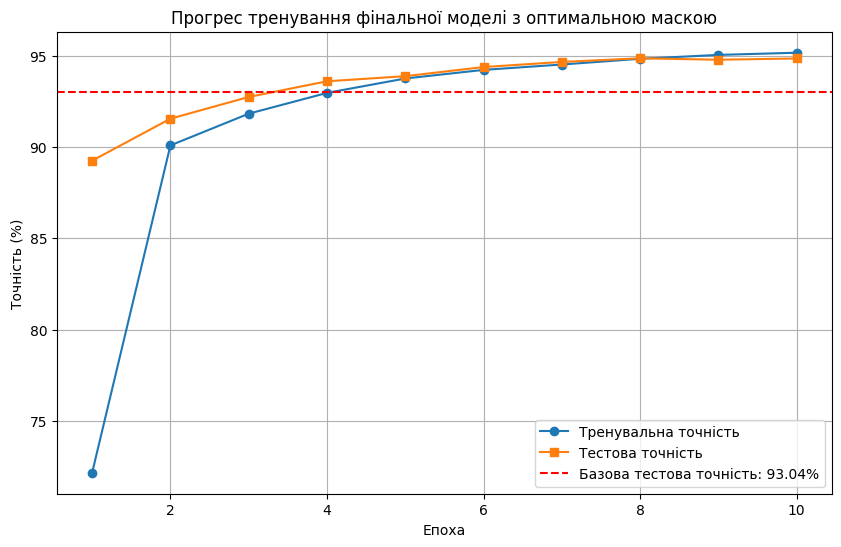

In [14]:
# Тренування фінальної моделі з оптимальною маскою
print("\nТренування фінальної моделі з оптимальною маскою (10 епох)...")
X_optimal = X[:, optimal_mask]
X_test_optimal = X_test[:, optimal_mask]
final_model, final_train_acc, final_test_acc = train_and_evaluate_model(
    X_optimal, y, X_test_optimal, y_test, optimal_result['kept_pixels'], epochs=10
)

# Візуалізація прогресу навчання фінальної моделі
plt.figure(figsize=(10, 6))
epochs = range(1, len(final_train_acc) + 1)
plt.plot(epochs, final_train_acc, 'o-', label='Тренувальна точність')
plt.plot(epochs, final_test_acc, 's-', label='Тестова точність')
plt.axhline(y=base_test_acc[-1], color='r', linestyle='--', label=f'Базова тестова точність: {base_test_acc[-1]:.2f}%')
plt.xlabel('Епоха')
plt.ylabel('Точність (%)')
plt.title('Прогрес тренування фінальної моделі з оптимальною маскою')
plt.legend()
plt.grid(True)
plt.show()


Фінальні результати:
Збережено 705 пікселів (89.92%)
Фінальна точність на тестовому наборі: 94.85%
Різниця точності порівняно з базовою лінією: 1.81%


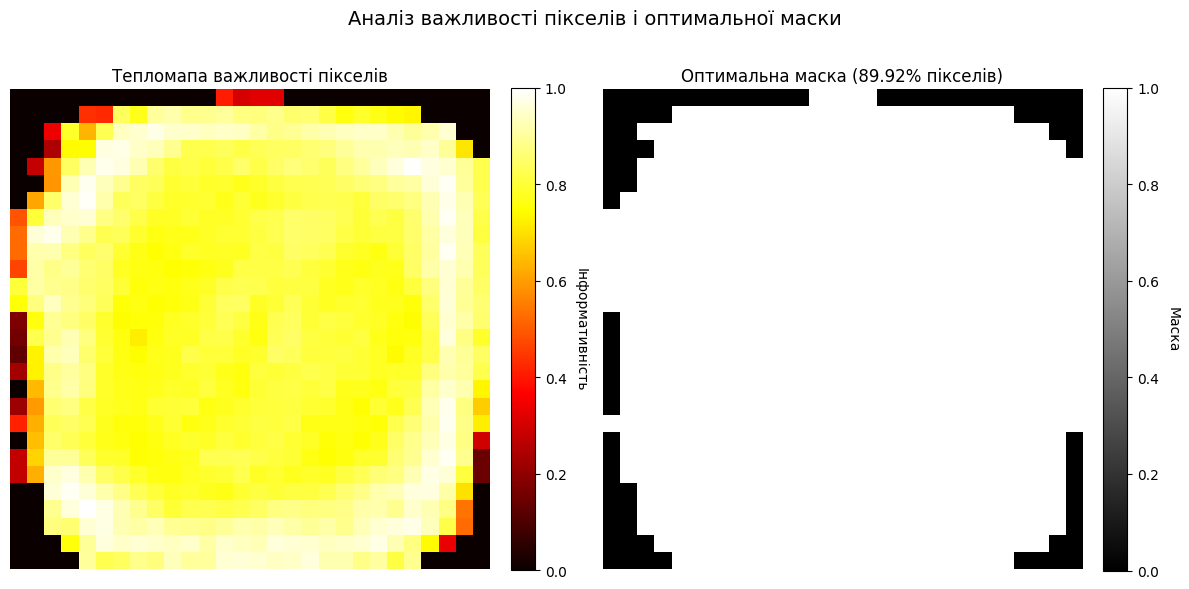

In [15]:
print(f"\nФінальні результати:")
print(f"Збережено {optimal_result['kept_pixels']} пікселів ({optimal_result['kept_percentage']:.2f}%)")
print(f"Фінальна точність на тестовому наборі: {final_test_acc[-1]:.2f}%")
print(f"Різниця точності порівняно з базовою лінією: {final_test_acc[-1] - base_test_acc[-1]:.2f}%")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Тепломапа важливості пікселів
im0 = axes[0].imshow(importance.reshape(28, 28), cmap='hot', interpolation='nearest')
axes[0].set_title('Тепломапа важливості пікселів', fontsize=12)
axes[0].axis('off')
cbar0 = plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
cbar0.ax.set_ylabel("Інформативність", rotation=270, labelpad=15)

# Маска пікселів (оптимальна)
im1 = axes[1].imshow(optimal_mask.reshape(28, 28), cmap='gray', interpolation='nearest')
axes[1].set_title(f'Оптимальна маска ({optimal_result["kept_percentage"]:.2f}% пікселів)', fontsize=12)
axes[1].axis('off')
cbar1 = plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
cbar1.ax.set_ylabel("Маска", rotation=270, labelpad=15)

plt.suptitle("Аналіз важливості пікселів і оптимальної маски", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
